In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
from datasets import load_dataset
ecommerceDataset = load_dataset('csv', data_files='../input/ecommerce-text-classification/ecommerceDataset.csv',cache_dir="./", names=["label", "description"])
ecommerceDataset

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to ./csv/default-49d8b7a373d3213e/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['label', 'description'],
        num_rows: 50425
    })
})

In [2]:
ecommerceDataset["train"][0]

{'label': 'Household',
 'description': 'Paper Plane Design Framed Wall Hanging Motivational Office Decor Art Prints (8.7 X 8.7 inch) - Set of 4 Painting made up in synthetic frame with uv textured print which gives multi effects and attracts towards it. This is an special series of paintings which makes your wall very beautiful and gives a royal touch. This painting is ready to hang, you would be proud to possess this unique painting that is a niche apart. We use only the most modern and efficient printing technology on our prints, with only the and inks and precision epson, roland and hp printers. This innovative hd printing technique results in durable and spectacular looking prints of the highest that last a lifetime. We print solely with top-notch 100% inks, to achieve brilliant and true colours. Due to their high level of uv resistance, our prints retain their beautiful colours for many years. Add colour and style to your living space with this digitally printed painting. Some are

In [3]:
import pandas as pd
ecommerceDataset.set_format(type="pandas")
df = ecommerceDataset["train"][:]
df.head()

,label,description
0,Household,Paper Plane Design Framed Wall Hanging Motivat...
1,Household,"SAF 'Floral' Framed Painting (Wood, 30 inch x ..."
2,Household,SAF 'UV Textured Modern Art Print Framed' Pain...
3,Household,"SAF Flower Print Framed Painting (Synthetic, 1..."
4,Household,Incredible Gifts India Wooden Happy Birthday U...


In [4]:
# Dataframe Shape
df.shape

(50425, 2)

In [5]:
#Checking if null value exists
df.isnull().sum()

label          0
description    1
dtype: int64

In [6]:
#dropping the null rows
df=df.dropna()
df.isnull().sum()

label          0
description    0
dtype: int64

In [7]:
# Unique labels
import numpy as np
for label in np.unique(df['label']):
    print(label)

Books
Clothing & Accessories
Electronics
Household


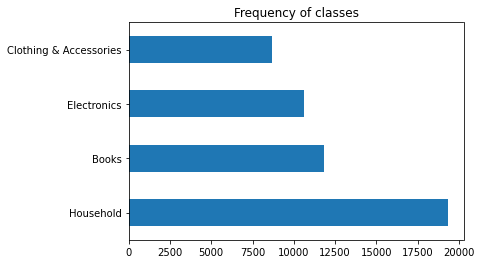

In [8]:
import matplotlib.pyplot as plt
df["label"].value_counts().plot.barh()
plt.title("Frequency of classes")
plt.show()

In [9]:
# Encode the labels into numeric
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['label'] = le.fit_transform(df['label'])
df.head()

,label,description
0,3,Paper Plane Design Framed Wall Hanging Motivat...
1,3,"SAF 'Floral' Framed Painting (Wood, 30 inch x ..."
2,3,SAF 'UV Textured Modern Art Print Framed' Pain...
3,3,"SAF Flower Print Framed Painting (Synthetic, 1..."
4,3,Incredible Gifts India Wooden Happy Birthday U...


In [10]:
# Text Preprocessing
import re
from nltk.corpus import stopwords
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing.
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text

In [11]:
df['description'] = df['description'].apply(clean_text)
df['description'] = df['description'].str.replace('\d+', '')
df.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


,label,description
0,3,paper plane design framed wall hanging motivat...
1,3,saf floral framed painting wood inch x inch ...
2,3,saf uv textured modern art print framed painti...
3,3,saf flower print framed painting synthetic in...
4,3,incredible gifts india wooden happy birthday u...


In [12]:
descriptions = df["description"].map(str).values.tolist()
labels = df["label"].values.tolist()

In [13]:
from transformers import DistilBertTokenizer, DistilBertModel, DistilBertForSequenceClassification
from transformers import Trainer, TrainingArguments
from transformers import EarlyStoppingCallback
import torch
model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=4)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.bias', 'pre_classifi

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
       

In [14]:
tokenizer = DistilBertTokenizer.from_pretrained(
        "distilbert-base-uncased",
        do_lower_case=True)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

In [15]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(descriptions, labels, test_size=0.4, stratify=labels, random_state=42)
x_valid, x_test, y_valid, y_test = train_test_split(x_test, y_test, test_size=0.5, random_state=42)

In [16]:
def get_batch_tokenizer(tokenizer, dataset):
    return tokenizer.batch_encode_plus(dataset,
                                       max_length=256,
                                       padding=True,
                                       truncation=True,
                                       add_special_tokens=True,
                                       return_attention_mask=True,
                                       return_tensors='pt')

In [17]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val
                in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [18]:
x_train_tokens = get_batch_tokenizer(tokenizer, x_train)
x_valid_tokens = get_batch_tokenizer(tokenizer, x_valid)
x_test_tokens = get_batch_tokenizer(tokenizer, x_test)

In [19]:
train_dataset = Dataset(x_train_tokens, y_train)
valid_dataset = Dataset(x_valid_tokens, y_valid)
test_dataset = Dataset(x_test_tokens, y_test)

In [20]:
args = TrainingArguments(output_dir="output",
                            evaluation_strategy="epoch",
                            metric_for_best_model="f1",
                            save_strategy="epoch",
                            num_train_epochs=3,
                            load_best_model_at_end=True
                            )

In [24]:
from sklearn.metrics import f1_score, classification_report
def compute_metrics(p):
    prediction, labels = p
    preds_flat = np.argmax(prediction, axis=1).flatten()
    labels_flat = labels.flatten()
    f1 = f1_score(labels_flat, preds_flat, average='macro')
    return {"f1": f1}


In [25]:
trainer = Trainer(args=args,
                    model=model,
                    train_dataset=train_dataset,
                    eval_dataset=valid_dataset,
                    compute_metrics=compute_metrics,
                    callbacks=[EarlyStoppingCallback(
                            early_stopping_patience=3)]
                    )

In [26]:
trainer.train()

/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 30254
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 11346
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


Epoch,Training Loss,Validation Loss,F1
1,0.108200,0.170478,0.971199
2,0.063700,0.138494,0.978867
3,0.038100,0.141461,0.978557


***** Running Evaluation *****
  Num examples = 10085
  Batch size = 8
Saving model checkpoint to output/checkpoint-3782
Configuration saved in output/checkpoint-3782/config.json
Model weights saved in output/checkpoint-3782/pytorch_model.bin
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
***** Running Evaluation *****
  Num examples = 10085
  Batch size = 8
Saving model checkpoint to output/checkpoint-7564
Configuration saved in output/checkpoint-7564/config.json
Model weights saved in output/checkpoint-7564/pytorch_model.bin
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.ten

TrainOutput(global_step=11346, training_loss=0.07179853039066901, metrics={'train_runtime': 1423.9494, 'train_samples_per_second': 63.74, 'train_steps_per_second': 7.968, 'total_flos': 6011717431652352.0, 'train_loss': 0.07179853039066901, 'epoch': 3.0})

In [27]:
trainer = Trainer(model=model)
predictions = trainer.predict(test_dataset)

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running Prediction *****
  Num examples = 10085
  Batch size = 8
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


In [28]:
preds = np.argmax(predictions.predictions, axis=1).flatten()
true_vals = predictions.label_ids

In [29]:
print(classification_report(true_vals, preds, target_names=list(le.classes_)))

                        precision    recall  f1-score   support

                 Books       0.98      0.98      0.98      2335
Clothing & Accessories       0.99      0.98      0.98      1772
           Electronics       0.98      0.97      0.97      2111
             Household       0.98      0.99      0.98      3867

              accuracy                           0.98     10085
             macro avg       0.98      0.98      0.98     10085
          weighted avg       0.98      0.98      0.98     10085

